This notebook will specifically use data from the Allen Insitute for Neural Dynamics and show how we can leverage CEBRA to analyse our in-house data. Here we will check if we can distinguish right vs left trials in the foraging task data.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils


from matplotlib.collections import LineCollection
import pandas as pd

## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
pd.__version__

'2.0.0'

In [3]:
#pip install pandas==2.0.0

In [4]:
# load the dataframe that contains data from 1 session
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [5]:
df_trials_ses.columns

Index(['bit_code', 'ses_idx', 'rpe', 'left_action_value', 'right_action_value',
       'licks L', 'licks R', 'Lick L (raw)', 'Lick R (raw)', 'trial', 'reward',
       'choice', 'go_cue_absolute_time', 'go_cue', 'choice_time',
       'reward_time', 'onset', 'NM', 'NM_name', 'region', 'last_value_NM',
       'overlap_index', 'NM_no_overlap', 'bins_mids', 'bins_mids_no_overlap'],
      dtype='object')

In [6]:
n_trials = 1765

In [7]:
# download the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [8]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [9]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [10]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape


(218572, 4)

In [11]:
all_nms.shape

(218572, 4)

In [12]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [13]:
# convert it to a tensor (this is probably not necessary but we want it to be as close to the inputs in the previous notebook)
all_nms_tensor = torch.from_numpy(all_nms_new)
all_nms_tensor.shape

torch.Size([218572, 4])

## B. Format data and create the behavioural/auxiliary variables

Now let's format the data. We want to view the data in a 1 second window around the choice time at each trial in the session. The hope is that this will make it easy to identify the trials where it chose to lick left and those where it chose to lick right.

Each trial will be labelled as rewarded/unrewarded and this will be the behavioural variable we use for this analysis.

In [14]:
ins = np.argwhere(df_trials_ses['licks R'] > df_trials_ses['licks L'])

In [15]:
df_trials_ses['licks L'].to_numpy()

array([26., 10.,  2., ...,  2.,  1.,  1.])

For the trials where the number of left and right trials are equal, the number of licks in either direction is either 0,1 or 2.

In [16]:
# Make a function to format the NM data into a 1s window around the choice
def format_data(neural_data, df, trace_times_, choice_times_ , window=None , window_size=10):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # define total number of trials
    n_total_trials = np.sum(np.unique(np.isnan(choice_times_),return_counts=True)[1])

    # list to hold all the 1s windows
    n_data_window = []

    # new labels
    reward_labels = []
    choice_labels = []
    rpe_labels = []
    n_licks = []


    # loop over all trials
    for i in range(0,n_total_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            reward_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            reward_labels.append(0)
        
        # label the timepoints as left or right choice
        if df['licks L'].iloc[i] >= df['licks R'].iloc[i]:
            # new trial label
            choice_labels.append(1)
            n_licks.append(df['licks L'].iloc[i])

        elif df['licks R'].iloc[i] > df['licks L'].iloc[i]:
            # new trial label
            choice_labels.append(0)
            n_licks.append(df['licks R'].iloc[i])

        # get the rpe values at each trial
        rpe_labels.append(df['rpe'].iloc[i])

    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    reward_labels = np.array(reward_labels)
    print("reward labels shape: ",reward_labels.shape)

    choice_labels = np.array(choice_labels)
    print("choice labels shape: ",choice_labels.shape)

    # convert rpe labels to arrays
    rpe_labels = np.array(rpe_labels)
    print("rpe labels shape:", rpe_labels.shape)


    return nms_HD, reward_labels, choice_labels, rpe_labels, n_licks

In [17]:
formatted_nms, reward_labels, choice_labels, rpe_labels, n_licks = format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)


In [18]:
if type(choice_labels) == np.ndarray:
    print('y')

else:
    print('n')

y


In [19]:
# define function to take the choice labels and make a 'Switch' label

def make_switch_label(choice_label):

    # make sure input is in array form
    assert type(choice_label)==np.ndarray

    switch_labels = []

    for i in range(0,choice_label.shape[0]):

        # should I just skip this first one?
        if i==0:
            switch_labels.append(0)
            continue

        # make switch label based on previous trial
        if choice_label[i]!=choice_label[i-1]:
            switch_labels.append(1)        
        
        elif choice_label[i]==choice_label[i-1]:
            switch_labels.append(0)

    switch_labels = np.array(switch_labels)
    print('Switch labels shape:', switch_labels.shape)

    return switch_labels


In [20]:
switch_labels = make_switch_label(choice_label=choice_labels)

Switch labels shape: (1717,)


## C. Build and train the CEBRA models

In [21]:
# set the maximum number of iterations for training the model
max_iterations = 2000

In [22]:
# build a CEBRA-Time and CEBRA-Behaviour model
cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [23]:
cebra_behaviour_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

Train the two models

In [24]:
# train the time model (no labels here)
cebra_time_model.fit(formatted_nms)

pos:  0.9603 neg:  2.8266 total:  3.7869 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.36it/s]


CEBRA(batch_size=512, conditional='time', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

In [25]:
# train the behaviour model (use the labels here)
cebra_behaviour_model.fit(formatted_nms, switch_labels)

pos:  0.1948 neg:  6.0136 total:  6.2084 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 37.99it/s]


CEBRA(batch_size=512, conditional='time_delta', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

## D. Compute and view embeddings

Here, we compute the embeddings from the two trained models and then plot them.

In [26]:
time_embedding = cebra_time_model.transform(formatted_nms)

In [27]:
behaviour_embedding = cebra_behaviour_model.transform(formatted_nms)

In [28]:
# divide the labels into right and left
switch = switch_labels==1
stay = switch_labels==0

switch = switch.flatten()
stay = stay.flatten()

In [29]:
# get auc scores
mean_scores, errors = utils.get_auc([behaviour_embedding, time_embedding], trial_labels=switch_labels)
mean_scores

[0.6836612054833097, 0.5]

In [30]:
np.round(mean_scores,2)

array([0.68, 0.5 ])

Text(0.5, 0, 'latent 3')

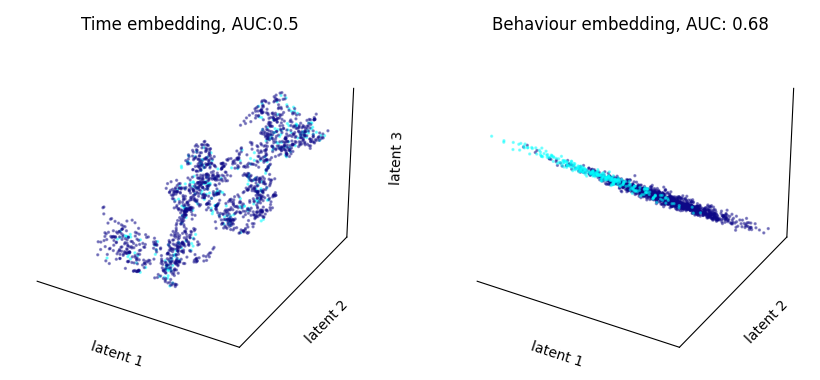

In [31]:
# create a figure and make the plots
fig1 = plt.figure(figsize=(16,4))
gs = gridspec.GridSpec(1, 2, figure=fig1)

ax1 = fig1.add_subplot(gs[0,0], projection='3d')
ax2 = fig1.add_subplot(gs[0,1], projection='3d')
axes =[ax1,ax2]

for ax in axes:


    ax.set_xlabel("latent 1", labelpad=0.01)
    ax.set_ylabel("latent 2", labelpad=0.01)
    ax.set_zlabel("latent 3", labelpad=0.01)

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.zaxis.set_tick_params(labelright=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])


# colour maps
colours = ['cool', 'plasma']

# Aucs rounded
mean_scores = np.round(mean_scores,2)

# plot the time embedding 
cebra.plot_embedding(embedding=time_embedding[switch,:], embedding_labels=switch_labels[switch],ax=ax1, markersize=2, title='Time embedding', cmap=colours[0])
cebra.plot_embedding(embedding=time_embedding[stay,:], embedding_labels=switch_labels[stay],ax=ax1, markersize=2, title='Time embedding, AUC:{}'.format(mean_scores[1]), cmap=colours[1])

# plot the behaviour embedding 
cebra.plot_embedding(embedding=behaviour_embedding[switch,:], embedding_labels=switch_labels[switch],ax=ax2, markersize=2, title='Behaviour embedding', cmap=colours[0])
cebra.plot_embedding(embedding=behaviour_embedding[stay,:], embedding_labels=switch_labels[stay],ax=ax2,markersize=2, title='Behaviour embedding, AUC: {}'.format(mean_scores[0]),  cmap=colours[1])


# Adjust the subplot layout manually
#plt.subplots_adjust(left=0.095, right=0.1, top=0.95, bottom=0.05, wspace=0.001)

# Adjust the subplot layout manually
plt.subplots_adjust(left=0.00001, right=0.55, top=0.95, bottom=0.05, wspace=0.0001)

# Use tight_layout with padding to ensure labels are not cut off


# Adjust label positions using bbox
ax2.set_zlabel("latent 3", labelpad=1, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', pad=0.5))


In [32]:
np.unique(switch_labels, return_counts=True)

(array([0, 1]), array([1441,  276]))

In [33]:
# build, train and compute with the time and behaviour models with this new labels
t_embed,b_embed =  utils.build_train_compute(formatted_nms,switch_labels)

pos:  0.9297 neg:  2.8660 total:  3.7957 temperature:  1.0000: 100%|██████████| 2000/2000 [00:49<00:00, 40.41it/s]
pos:  0.1655 neg:  6.0445 total:  6.2100 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 38.61it/s]


In [34]:
# define a function to view the embeddings
def view(time_embedding, behaviour_embedding, labels, label_classes, size=5):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
 

    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax81, markersize=size, title='Time embedding', cmap=colours[1])
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax81, markersize=size, title='Time embedding', cmap=colours[0])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1]],ax=ax82, markersize=size, title='Behaviour embedding', cmap=colours[1])
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0]],ax=ax82,markersize=size, title='Behaviour embedding',  cmap=colours[0])

    gs.tight_layout(figure=fig)

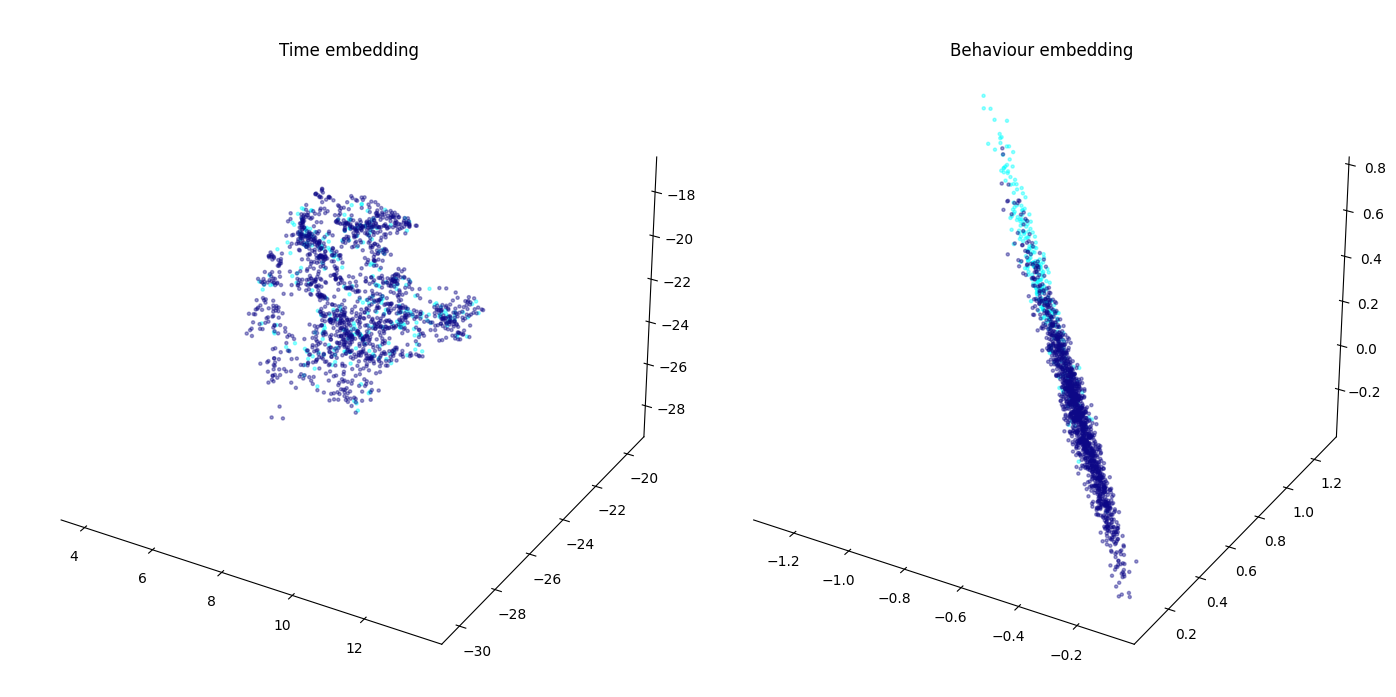

In [35]:
view(t_embed, b_embed,switch_labels, [switch,stay])

try this with the infoNCE setting -- maybe the behaviour embedding will make sense then

In [36]:
individual_nms = utils.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [37]:
b_embeds, t_embeds, sw_labels, [switch, stay] = utils.nm_analysis_2(individual_nms, df_trials_ses, trace_times, choice_times, title=" ",label='switch')

neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
Switch labels shape: (1717,)


pos:  0.5904 neg:  4.5191 total:  5.1094 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.94it/s]
pos:  0.0826 neg:  6.1569 total:  6.2395 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 38.61it/s]


COMPLETED ANALYSIS OF NM 0
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
Switch labels shape: (1717,)


pos:  0.8085 neg:  3.9779 total:  4.7864 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.79it/s]
pos:  0.0788 neg:  6.1550 total:  6.2338 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 38.15it/s]


COMPLETED ANALYSIS OF NM 1
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
Switch labels shape: (1717,)


pos:  0.8123 neg:  4.8822 total:  5.6945 temperature:  1.0000: 100%|██████████| 2000/2000 [00:49<00:00, 40.35it/s]
pos:  0.0395 neg:  6.1988 total:  6.2383 temperature:  1.0000: 100%|██████████| 2000/2000 [00:54<00:00, 37.03it/s]


COMPLETED ANALYSIS OF NM 2
neural tensor shape:  torch.Size([1717, 20])
reward labels shape:  (1717,)
choice labels shape:  (1717,)
rpe labels shape: (1717,)
Switch labels shape: (1717,)


pos:  0.5809 neg:  4.7726 total:  5.3535 temperature:  1.0000: 100%|██████████| 2000/2000 [00:51<00:00, 38.60it/s]
pos:  0.0488 neg:  6.1847 total:  6.2335 temperature:  1.0000: 100%|██████████| 2000/2000 [00:54<00:00, 36.43it/s]


COMPLETED ANALYSIS OF NM 3


In [38]:
len(b_embeds)

4

In [39]:
means, sds = utils.get_auc(b_embeds, sw_labels)

In [40]:
means

[0.5496434641804705,
 0.5521490209093927,
 0.5178456486538133,
 0.5250920254654075]

In [41]:
# first make function to make the plots given a list of embeddings
def plot4_embeddings(embeddings, labels , l_class, means=None, titles=['DA only', 'NE only', '5HT only', 'ACh only'], t=""):

    # number of plots
    n_plots = len(embeddings)

    n_columns = 2
    n_rows = n_plots//n_columns

    # create axis
    fig = plt.figure(figsize=(8,4*n_plots))
    gs = gridspec.GridSpec(n_rows, n_columns, figure=fig)

    # colour 
    c = ['cool','plasma','pink','winter']

    for i, embed in enumerate(embeddings):

        # create the axes
        ax = fig.add_subplot(gs[i // n_columns, i%n_columns], projection='3d')

        ax.set_xlabel("latent 1", labelpad=0.001, fontsize=13)
        ax.set_ylabel("latent 2", labelpad=0.001, fontsize=13)
        ax.set_zlabel("latent 3", labelpad=0.001, fontsize=13)

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.zaxis.set_tick_params(labelright=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])


        if means.any():
            titles=['DA only, AUC:{}'.format(means[0]),'NE only, AUC:{}'.format(means[1]), '5HT only, AUC:{}'.format(means[2]), 'ACh only, AUC:{}'.format(means[3])]


        # plot the embedding
        cebra.plot_embedding(embedding=embed[l_class[0],:], embedding_labels=labels[l_class[0]], ax=ax, markersize=2,title=titles[i], cmap=c[0])
        cebra.plot_embedding(embedding=embed[l_class[1],:], embedding_labels=labels[l_class[1]], ax=ax, markersize=2,title=titles[i], cmap=c[1])

    plt.suptitle(t, fontsize=15)
    plt.tight_layout()

In [42]:
np.round(means,2)

array([0.55, 0.55, 0.52, 0.53])

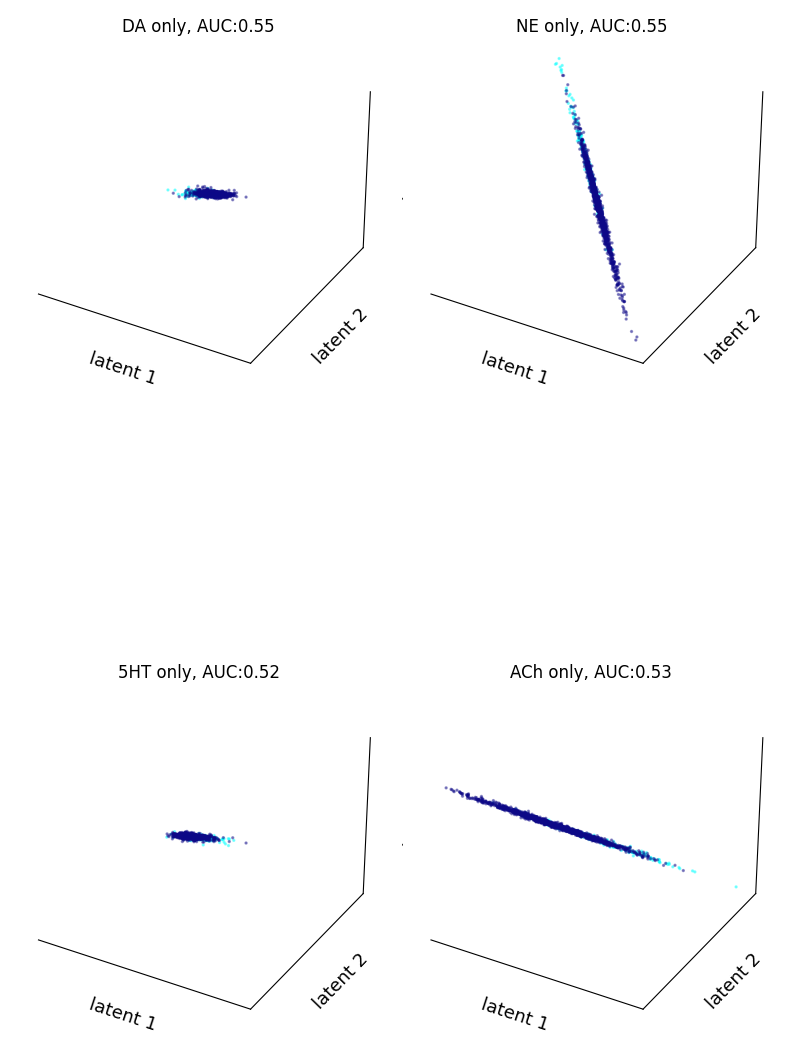

In [44]:
plot4_embeddings(b_embeds, sw_labels, [switch, stay], means=np.round(means,2))